In [1]:
!pip install tensorflow --quiet
!pip install tensorflow-hub --quiet
!pip install tensorflow-text --quiet
!pip install transformers --quiet

In [2]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,TFRobertaModel

tf.get_logger().setLevel('ERROR')
pd.set_option('display.max_colwidth', None)
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## Preprocess the Dataset

Here, we are going to use the same set of pre-processing steps we used in [one of the previous notebooks](https://www.kaggle.com/code/l048596/disaster-tweets-classifier-using-bert). You can find a detailed explanation of the steps in the link.

In [4]:
duplicates = train[train.duplicated('text')]
problematic_duplicates = []

for i in range(duplicates.text.nunique()):
    duplicate_subset = train[train.text == duplicates.text.unique()[i]]
    if len(duplicate_subset) > 1 and duplicate_subset.target.nunique() == 2:
        problematic_duplicates.append(i)
        
print(problematic_duplicates)

[4, 7, 12, 15, 24, 26, 33, 34, 35, 36, 38, 39, 42, 44, 46, 51, 55, 58]


In [5]:
target_list = [0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0]

for problematic_index in range(len(problematic_duplicates)): 
    train.target = np.where(train.text == duplicates.text.unique()[problematic_index], 
                            target_list[problematic_index], train.target)

In [6]:
def clean_text(dataframe):
    dataframe.text = dataframe.text.apply(lambda x: str.lower(x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'http\S+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'#', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'@', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\n', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
    return(dataframe)

In [7]:
clean_train = clean_text(train)
clean_train_balanced = clean_train.groupby('target').sample(3000, random_state = 1048596)

In [8]:
clean_train_balanced.head(5)

,id,keyword,location,text,target
7342,10513,wildfire,"Columbus, OH",i honestly wonder what it is that i had to do so wrong to lose everyone,0
4795,6821,loud%20bang,"Wandsworth, London",sw_trains strange loud impact bang noises under train to epsom about to arrive wimbledon,0
1652,2387,collapsed,I'm standing behind you,rokiieee_ the game has officially collapsed,0
1435,2070,casualty,"Santa Monica, CA",1st quality insurance group is hiring licensed property amp casualty insurance agent produc jobs denver,0
1666,2408,collide,NaN,and when those waves shall ripple collide its on the tide of your love i will survive love lesleychappelle,0


In this notebook, we are going to use **train_test_split** instead of **np.split** to split our dataset into training and validation datasets. This just helps us better reference the texts and labels to use when training the model. 

In [9]:
x_train, x_val, y_train, y_val = train_test_split(clean_train_balanced.text, 
                                                  clean_train_balanced.target, 
                                                  train_size = 0.85, 
                                                  random_state = 1048596)

The biggest change in this iteration is the tokenizer and the BERT model we are going to fine-tune for the classification task. So far, we have been using BERT-base and Small-BERT models that are made available through tensorflow hub. However, given that we are attempting to classify tweets, there may be pre-trained models that are more appropriate for the purpose of classifying tweets. **BERTweet** is a pre-trained language model designed forr English tweets and have been shown to perform better compared to other state-of-the-art language models for many NLP tasks including text classification. 

In [10]:
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', 
                                          normalization = True, 
                                          use_fast = False,
                                          add_special_tokens = True,
                                          pad_to_max_length = True,
                                          return_attention_mask = True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
train_token = tokenizer(x_train.tolist(), 
                        padding = "max_length", 
                        truncation = True).data

val_token = tokenizer(x_val.tolist(),
                      padding = "max_length", 
                      truncation = True).data

train_features = {x: train_token[x] for x in tokenizer.model_input_names}
train_features = tf.data.Dataset.from_tensor_slices((train_features, y_train))
train_features = train_features.shuffle(len(x_train)).batch(32).prefetch(tf.data.AUTOTUNE)

val_features = {x: val_token[x] for x in tokenizer.model_input_names}
val_features = tf.data.Dataset.from_tensor_slices((val_features, y_val))
val_features = val_features.shuffle(len(x_val)).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
bert_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

input_ids = tf.keras.Input(shape=(128,), dtype = 'int32', name = 'input_ids')
attention_masks = tf.keras.Input(shape=(128,), dtype ='int32', name = 'attention_mask')

output = bert_model([input_ids,attention_masks])[1]
output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
model.compile(optimizer=tfa.optimizers.AdamW(weight_decay = 1e-6, lr=1e-5), loss='binary_crossentropy',metrics = ['accuracy'])

#only training last layer:
model.layers[2].trainable = False

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [14]:
history = model.fit(train_features, 
                    epochs = 30,
                    validation_data = val_features,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


160/160 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.7800
Epoch 1: val_loss improved from inf to 0.41598, saving model to model/best_performed_model.ckpt
160/160 [==============================] - 109s 565ms/step - loss: 0.4756 - accuracy: 0.7800 - val_loss: 0.4160 - val_accuracy: 0.8244
Epoch 2/30
160/160 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8453
Epoch 2: val_loss improved from 0.41598 to 0.40703, saving model to model/best_performed_model.ckpt
160/160 [==============================] - 87s 543ms/step - loss: 0.3691 - accuracy: 0.8453 - val_loss: 0.4070 - val_accuracy: 0.8233
Epoch 3/30
160/160 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8765
Epoch 3: val_loss did not improve from 0.40703
160/160 [==============================] - 82s 510ms/step - loss: 0.3133 - accuracy: 0.8765 - val_loss: 0.4456 - val_accuracy: 0.8089
Epoch 4/30
160/160 [==============================] - ETA: 0s - loss: 0.2748 

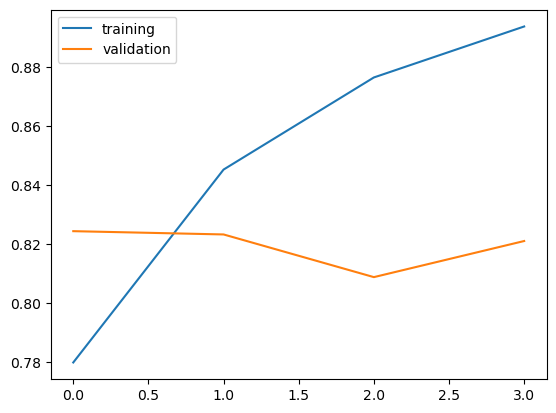

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

In [16]:
clean_test = clean_text(test)

test_token = tokenizer(clean_test.text.tolist(), 
                       padding = "max_length", 
                       truncation = True,
                       return_tensors='tf').data

In [17]:
predictions = model.predict(test_token)

102/102 [==============================] - 20s 166ms/step


In [18]:
final_predictions = [(x > 0.5).astype(int) for x in predictions]
predictions_df = pd.DataFrame(list(zip(test.id, final_predictions)),
                              columns = ['id', 'target'])

predictions_df.to_csv('predictions.csv', index = False)